In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
import csv
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory
from scipy import linalg as slinalg

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
env = gym2.make('Linear-v1')

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(16, activation="relu")(x)
    x1 = Dense(16, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(16, activation="relu")(x)
    x2 = Dense(16, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output_large")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor


In [4]:
alpha = 0.1
beta = .5

In [5]:
def interaction(state, u, tau, env, ln=0):
    env.reset()
    x = np.array(state)
    env.set_state(x)
    reward = 0
    a_agent, tau = u, tau
    tau = np.clip(tau, 0.01, 10.)
    action_repetition = int(np.ceil(100 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = .01
    for p in range(action_repetition):
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln)
        r *= np.exp(- alpha * p * dt)
        reward += r
    reward *= dt
    reward -= beta
    state1 = env.state
    return reward, state1

# 評価
def evaluation(actor, init_state = np.array([1,2])):
    x = init_state
    episode_time = 0
    episode_reward = 0
    log = []
    while True:
        a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
        log.append([x, episode_time])
        reward, x = interaction(x, a_agent, tau, env, ln=0.)
        episode_reward += np.exp(- alpha * episode_time) * reward
        episode_time += tau
        if episode_time >= 30.:
            log.append([x, episode_time])
            break
    return episode_reward

In [6]:
p = branch_actor((2,),(2,))
q = branch_actor((2,),(2,))
m = branch_actor((2,),(2,))
b = branch_actor((2,),(2,))
p.load_weights('../saved_agent/learned_self_linear_ideal5_actor.h5')
q.load_weights('../saved_agent/learned_self_linear_proposed4_actor.h5')
m.load_weights('../saved_agent/mb_self_extend_noisy_actor.h5')
b.load_weights('../saved_agent/bad_self_actor.h5')

In [7]:
s1 = np.linspace(-7, 7, 10)
s2 = np.linspace(-7, 7, 10)
S1, S2 = np.meshgrid(s1, s2)
S1, S2 = S1.flatten(), S2.flatten()

ev_p = []
ev_q = []
ev_m = []
ev_b = []

for i, x in enumerate(zip(S1, S2)):
    x = np.array(x)
    ev_p.append(evaluation(p, init_state=x))
    ev_q.append(evaluation(q, init_state=x))
    ev_m.append(evaluation(m, init_state=x))
    ev_b.append(evaluation(b, init_state=x))
    print(f'{int(i*100/len(S1))}%\r',end='')

In [8]:
# ideal learning (small n_steps)
print(np.mean(ev_p), np.max(ev_p), np.min(ev_p))

-8.954730999320173 -4.652737813470088 -36.533575899469405


In [9]:
# practical
print(np.mean(ev_q), np.max(ev_q), np.min(ev_q))

-11.986561081591695 -9.418245301331298 -22.081668096640097


In [10]:
# naiive
print(np.mean(ev_m), np.max(ev_m), np.min(ev_m))

-19.605850573533203 -15.386024613028132 -22.95265151974251


In [11]:
# proposed 2 bad
print(np.mean(ev_b), np.max(ev_b), np.min(ev_b))

-479.71211911203886 -478.7197579811124 -481.0511704309415


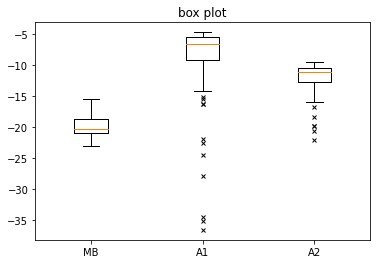

In [75]:
fig, ax = plt.subplots()
pink_tri = dict(marker='x',ms=4)
ax.boxplot([ev_m, ev_p, ev_q], labels=['MB', 'A1', 'A2'], flierprops=pink_tri)
ax.set_title('box plot')
plt.show()